# Using _egobox_ surrogate model _SparseGpx_

This tutorial is inspired from SGP tutorial from [SMT](https://github.com/SMTOrg/smt/tutorial).

## Installation

In [1]:
%pip install egobox

Note: you may need to restart the kernel to use updated packages.


We import _egobox_ as _egx_ for short

In [2]:
import egobox as egx

# Example 1 : SparseGpx basics

### Training 

#### Benchmark function definition

In [3]:
import numpy as np

def f_obj(x):
    return np.sin(3*np.pi*x) + 0.3*np.cos(9*np.pi*x) + 0.5*np.sin(7*np.pi*x)

#### Training data definition

In [4]:
# number of observations
N = 200

# noise
eta = 0.01

# Set seed via random generator for reproducibility
rng = np.random.RandomState(0)

# generate data
xt = 2*np.random.rand(N, 1) - 1
yt = f_obj(xt) + rng.normal(loc=0.0, scale=np.sqrt(eta), size=(N,1))

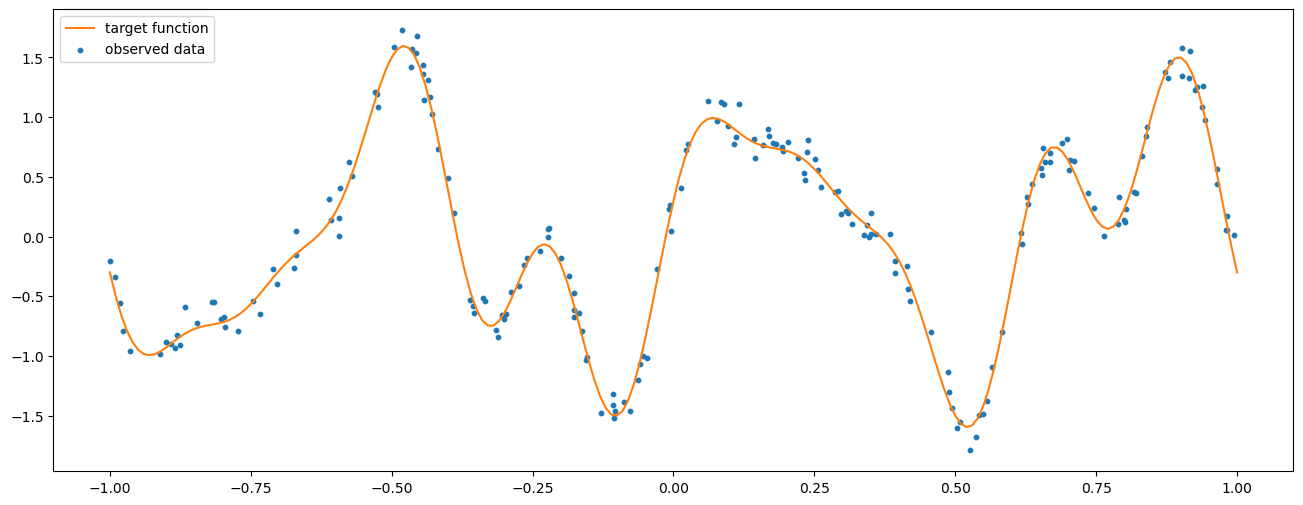

In [5]:
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 201).reshape(-1,1)
y = f_obj(x)

plt.figure(figsize=(16, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.xlim([-1.1,1.1])
plt.legend(loc=0)
plt.show()

#### Building the surrogate

In order to ensure the proper convergence of optimization, we take an initial guess for theta based on the data std.\
Also, it can be useful to change the allowed bounds for this parameter.
    

In [14]:
# Initial guess for lengthscale parameter: standard deviation of training data
l = np.std(xt, axis=0)

# Transform to theta parameter (inverse of lengthscale)
theta0 = 1/l**2
print("theta0 :", theta0)

# Specify bounds for theta
bounds = [[1e-8, 1e2]] 

theta0 : [3.15920359]


In [29]:
sgpx = egx.SparseGpMix(theta_init=theta0, theta_bounds=bounds, nz=30, seed=0).fit(xt, yt)

# Print trained surrogate
print(sgpx)

Mixture[Smooth(1)]($regr_SquaredExponential)


### Prediction

#### Using the surrogate for estimation

In [30]:
hat_y = sgpx.predict_values(x)
var = sgpx.predict_variances(x)

#### Plotting results

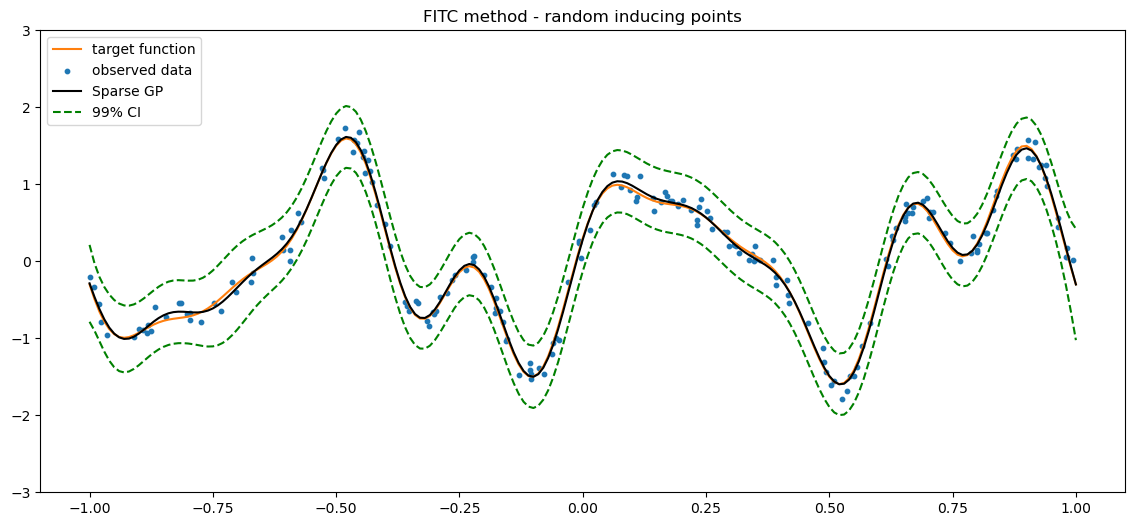

In [31]:
plt.figure(figsize=(14, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.plot(x, hat_y, "k-", label="Sparse GP")
plt.plot(x, hat_y - 3 * np.sqrt(var), "g--")
plt.plot(x, hat_y + 3 * np.sqrt(var), "g--", label="99% CI")
#plt.plot(Z1, -2.9 * np.ones_like(Z1), "r|", mew=2, label="inducing points - random")
plt.ylim([-3, 3])
plt.legend(loc=0)
plt.title('FITC method - random inducing points')
plt.show()